# DATA DOJO (7/06/2023 - Jean-Benoît DENIS)
## Nutriscorez vos aliments !
### Découverte du Machine Learning

## Le Nutri-score, qu'est ce que c'est ?

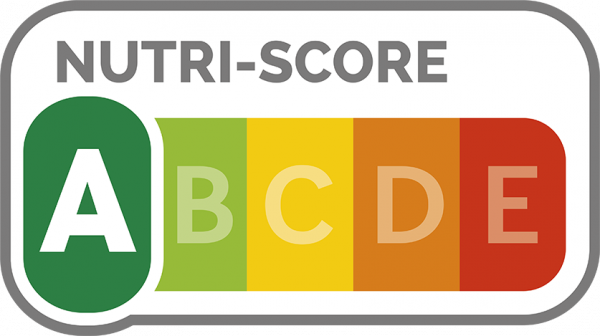

"Le Nutri-score est un logo apposé en face avant des emballages qui informe sur la qualité nutritionnelle des produits"

"Le Nutri-Score a été mis en place pour la première fois en France en 2017, en se basant sur les travaux de l’équipe du Pr. Serge Hercberg ainsi que sur l’expertise de l’Agence nationale de sécurité sanitaire (ANSES) et du Haut Conseil de la Santé Publique (HCSP)."

La méthode de calcul dépend de la nature du produit : 

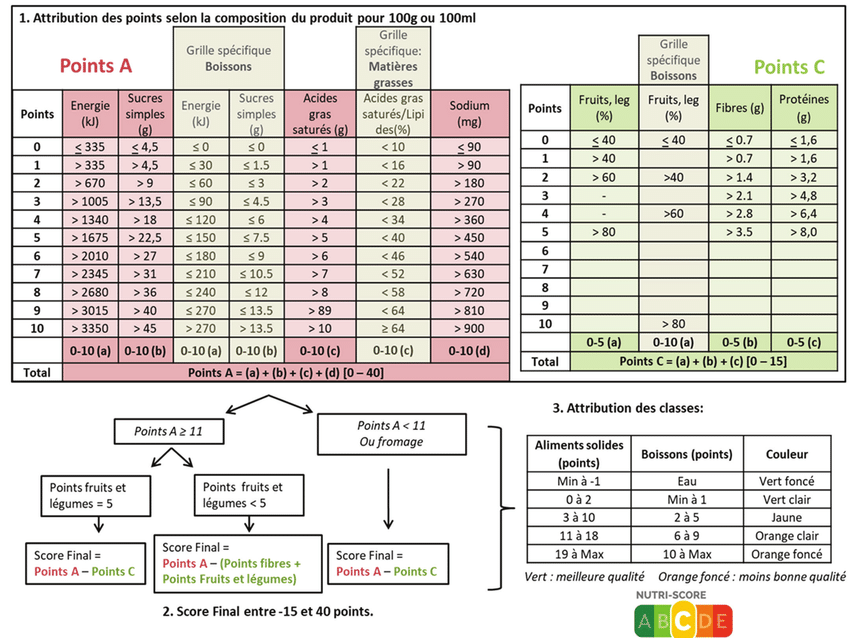

Pour plus d'informations : https://www.santepubliquefrance.fr/determinants-de-sante/nutrition-et-activite-physique/articles/nutri-score#:~:text=Le%20Nutri%2DScore%20a%20%C3%A9t%C3%A9,de%20l'%C3%A9quipe%20du%20Pr.

## Avec des Data c'est mieux!

### Open Food Facts

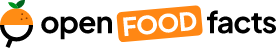

Open Food Facts est un projet collaboratif en ligne lancé en 2012 et dont le but est de constituer une base de données libre et ouverte sur les produits alimentaires commercialisés dans le monde entier. Cette base de données est alimentée directement par les consommateurs sous forme d’ajout de fiche produit alimentaire en se basant sur les données inscrites sur les emballages.

On retrouve diverses informations comme des tags indiquant l’origine ou la localisation du produit, les ingrédients composant le produit avec éventuellement la liste de leurs additifs, ou encore des informations nutritionnelles avec la quantité de tel ou tel nutriment dans le produit.

Cette base de donnée se compose de plus de 1 500 000 produits et rassembles des informations pour près de 200 indicateurs.

Pour plus d'informations : https://fr.openfoodfacts.org/

### Import des librairies

In [1]:
from collections import Counter
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler


# Tools for AutoML
from automl_script.pandas_eda import PandasEDA
from automl_script.features_engenering_engine import AcpReduction, FeaturesScaler
from automl_script.supervised_ml import SupMLEngine


/opt/conda/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


### Chargement des données et aperçu

Le jeu de donnée étudié ici à déjà subit plusieurs opérations de nettoyage 

##### *SOLUTION*

In [2]:
data=pd.read_csv("train_data_clean.csv",sep = '\t',low_memory=False)
data=data.drop('Unnamed: 0',axis=1)
data.head()

energy-kcal_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  \
0            800.00    100.00               14.29                0.00   
1            206.00      8.82                5.88               29.41   
2            262.77     13.14                5.84               24.82   
3            230.00     15.00                5.00                4.00   
4            229.00     14.29                8.57               22.86   

    sugars_100g  fiber_100g  proteins_100g  salt_100g  sodium_100g  \
0 -1.776357e-15        0.00           0.00     0.0000      0.00000   
1  2.059000e+01        0.00           2.94     0.2950      0.11800   
2  2.920000e+00        0.73          10.95     1.5759      0.63036   
3  1.000000e+00        0.00          18.00     2.0000      0.80000   
4  2.286000e+01        0.00           4.29     0.1425      0.05700   

   nutrition-score-fr_100g                                       product_name  \
0                     11.0                            100% pure vegetable oil   
1                     12.0  Caramel flavored dulce de leche ice cream with...   
2                     15.0                            Pizza perppeoni buttery   
3                     14.0                           Ukrainian garlic sausage   
4                     15.0                            Really creamy ice cream   

  nutriscore_grade  
0                d  
1                d  
2                d  
3                d  
4                d

## EDA

#### Commençons par observer ce qui nous interesse, le nutriscore. 



*TIPS: Observer le nombre d'entrée par Nutriscore*

##### *SOLUTION*

In [3]:
scor_A = data.copy()
scor_B = data.copy()
scor_C = data.copy()
scor_D = data.copy()
scor_E = data.copy()

scor_A=scor_A[scor_A['nutriscore_grade']=='a']
scor_A=scor_A.reset_index(drop=True)
scor_B=scor_B[scor_B['nutriscore_grade']=='b']
scor_B=scor_B.reset_index(drop=True)
scor_C=scor_C[scor_C['nutriscore_grade']=='c']
scor_C=scor_C.reset_index(drop=True)
scor_D=scor_D[scor_D['nutriscore_grade']=='d']
scor_D=scor_D.reset_index(drop=True)
scor_E=scor_E[scor_E['nutriscore_grade']=='e']
scor_E=scor_E.reset_index(drop=True)

In [4]:
#comparaison du nombre d'entrée 
print('la catégorie A possède : ', len (scor_A),'entrées')
print('la catégorie B possède : ', len (scor_B),'entrées')
print('la catégorie C possède : ', len (scor_C),'entrées')
print('la catégorie D possède : ', len (scor_D),'entrées')
print('la catégorie E possède : ', len (scor_E),'entrées')


la catégorie A possède :  8690 entrées
la catégorie B possède :  9119 entrées
la catégorie C possède :  12478 entrées
la catégorie D possède :  19517 entrées
la catégorie E possède :  10820 entrées


Text(0.5, 1.0, 'Nb entrée par score')

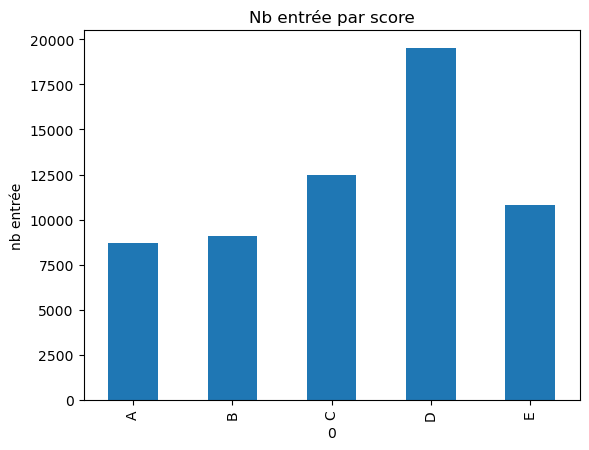

In [5]:
#nb d'entrée par catégorie
letter_frame=[scor_A,scor_B,scor_C,scor_D,scor_E]
taille_cat=[]
for i in letter_frame:
  taille_cat.append(len(i))

#graph bar représentant le nb d'entrée par catégorie
letter=pd.DataFrame(['A','B','C','D','E'])
letter['nb entrée']= taille_cat
letter=letter.set_index(letter.iloc[:,0])

plt.figure()
letter['nb entrée'].plot.bar()
plt.ylabel('nb entrée')
plt.title('Nb entrée par score')

*On remarque que le nombre d'entrée n'est pas le même pour chaque valeur de nutriscore, c'est à dire que le dataset est déséquilibré pour notre problématique, il faudra alors effectuer un **Sampling**.*

#### Regardons maintenant quelles informations nous avons.

*TIPS: Observer le contenu du data set (nature des indicateurs, stats, ordre de grandeur, etc.)*

##### *SOLUTION*

In [6]:
print(f"Le dataset contient {data.shape[0]} entrées et {data.shape[1]} colonnes")
print(f"les informations du dataset sont caractérisées selon les colonnes suivantes : {[c for c in data.columns]}")

Le dataset contient 60624 entrées et 12 colonnes
les informations du dataset sont caractérisées selon les colonnes suivantes : ['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g', 'product_name', 'nutriscore_grade']


*En observant simplement les noms des features, on peut imaginer que des liens doivent exister entre certains indicateurs. Il faudra analyser plus précisément ce point.*

Nous pouvons également regarder les indicateurs statistiques usuels pour chaques features par nutri-score.

In [7]:
data.describe()

energy-kcal_100g      fat_100g  saturated-fat_100g  carbohydrates_100g  \
count      60624.000000  60624.000000        60624.000000        60624.000000   
mean         251.968349     10.733442            3.962918           32.184337   
std          165.890175     14.358324            6.397282           28.740302   
min            0.000000      0.000000            0.000000            0.000000   
25%           99.000000      0.000000            0.000000            6.670000   
50%          250.000000      4.800000            1.020000           21.000000   
75%          375.000000     16.670000            5.810000           57.500000   
max          800.000000    100.000000          100.000000          100.000000   

        sugars_100g    fiber_100g  proteins_100g     salt_100g   sodium_100g  \
count  6.062400e+04  60624.000000   60624.000000  60624.000000  60624.000000   
mean   1.437431e+01      1.615702       7.014260      1.402778      0.561110   
std    1.977358e+01      2.309323       7.957177      4.611603      1.844639   
min   -1.776357e-15      0.000000       0.000000      0.000000      0.000000   
25%    1.160000e+00      0.000000       1.160000      0.133929      0.053571   
50%    4.760000e+00      0.800000       4.600000      0.750000      0.300000   
75%    2.143000e+01      2.480000      10.000000      1.517500      0.607000   
max    1.000000e+02     34.320000      90.910000    100.000000     40.000000   

       nutrition-score-fr_100g  
count             60624.000000  
mean                  9.242742  
std                   8.595145  
min                 -14.000000  
25%                   2.000000  
50%                  10.000000  
75%                  16.000000  
max                  38.000000

<Axes: >

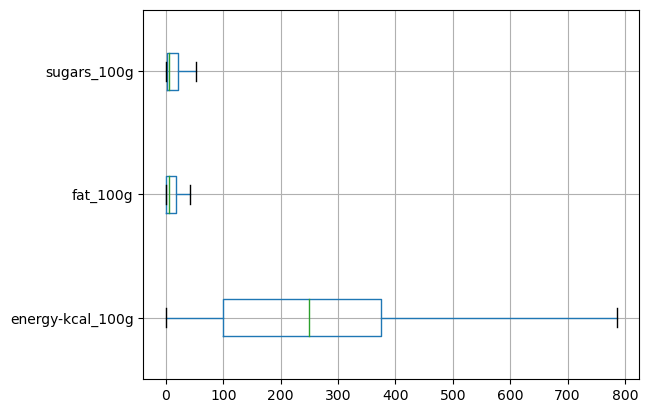

In [8]:
data.boxplot(column=["energy-kcal_100g", "fat_100g",
                    "sugars_100g"], vert=False, showfliers=False)

*On observe ici que les features n'ont pas toutes les mêmes ordres de grandeur, il faudra alors **Normaliser** ces features.*

#### AutoML Tools

In [45]:
# AutoML Tools
EDA = PandasEDA()
describe_df = EDA.df_describe(scor_A)
describe_df

Your selected dataframe has 12 columns and 8690 inputs


col_name col_type  unique_values  duplicated_values  \
0          energy-kcal_100g  float64           1038               7652   
1                  fat_100g  float64            998               7692   
2        saturated-fat_100g  float64            500               8190   
3        carbohydrates_100g  float64           2026               6664   
4               sugars_100g  float64            957               7733   
5                fiber_100g  float64            650               8040   
6             proteins_100g  float64           1328               7362   
7                 salt_100g  float64           1248               7442   
8               sodium_100g  float64           1220               7470   
9   nutrition-score-fr_100g  float64             15               8675   
10             product_name   object           8690                  0   
11         nutriscore_grade   object              1               8689   

           max           min        mean    median           var         std  \
0   714.000000  0.000000e+00  163.117576  106.0000  17460.868370  132.139579   
1    93.333333  0.000000e+00    2.469505    1.1800     32.865456    5.732840   
2    13.333333  0.000000e+00    0.357539    0.0000      0.614866    0.784134   
3    91.040000  0.000000e+00   27.722911   14.4000    757.540215   27.523448   
4    57.140000 -1.776357e-15    3.117008    2.3500     11.881984    3.447025   
5    34.320000  0.000000e+00    3.342746    2.8000     10.011734    3.164132   
6    90.000000  0.000000e+00    8.165430    7.2000     40.549614    6.367858   
7     1.760000  0.000000e+00    0.308518    0.1225      0.137076    0.370237   
8     0.704000  0.000000e+00    0.123407    0.0490      0.021932    0.148095   
9     1.000000 -1.400000e+01   -3.139471   -3.0000      3.921169    1.980194   
10         NaN           NaN         NaN       NaN           NaN         NaN   
11         NaN           NaN         NaN       NaN           NaN         NaN   

        skew   kurtosis  Nan  Nan_percent  
0   0.856231  -0.318784    0          0.0  
1   8.064860  82.198741    0          0.0  
2   4.247423  32.709605    0          0.0  
3   0.850286  -0.913017    0          0.0  
4   2.644466  17.176735    0          0.0  
5   2.083083   8.865797    0          0.0  
6   2.614555  21.556690    0          0.0  
7   1.113285   0.144532    0          0.0  
8   1.113278   0.144514    0          0.0  
9  -0.917817   0.640328    0          0.0  
10       NaN        NaN    0          0.0  
11       NaN        NaN    0          0.0

#### Pour avoir une idée de ce que représente chaque nutri-score, comparons les en fonction de certains indicateurs.

*TIPS: Regarder la composition de chaque nutri-score (ex: pie chart)*

##### *SOLUTION*

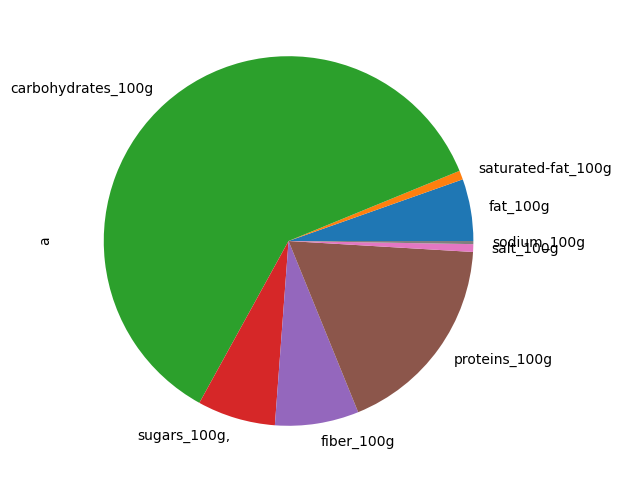

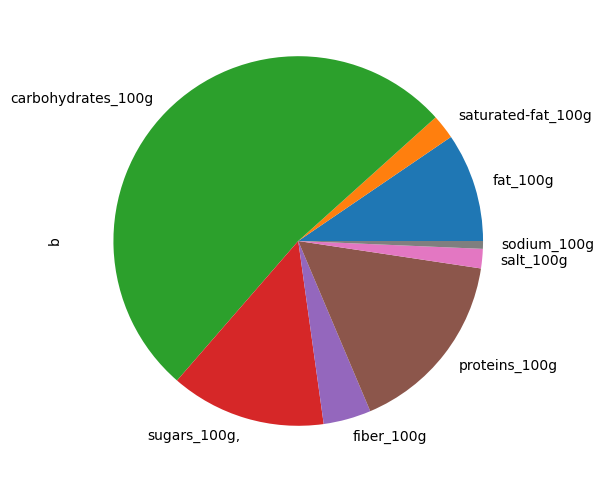

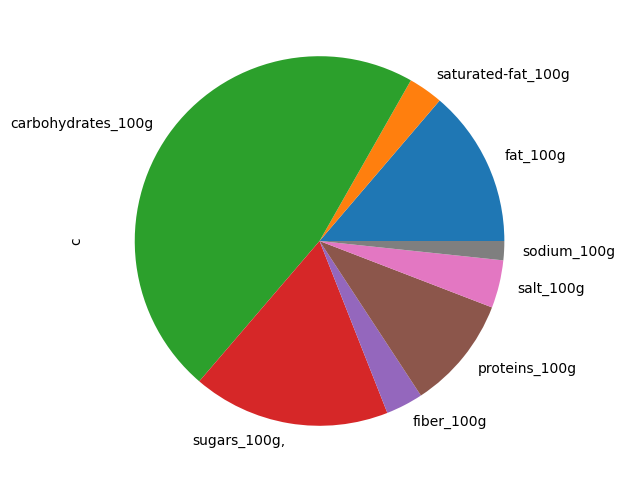

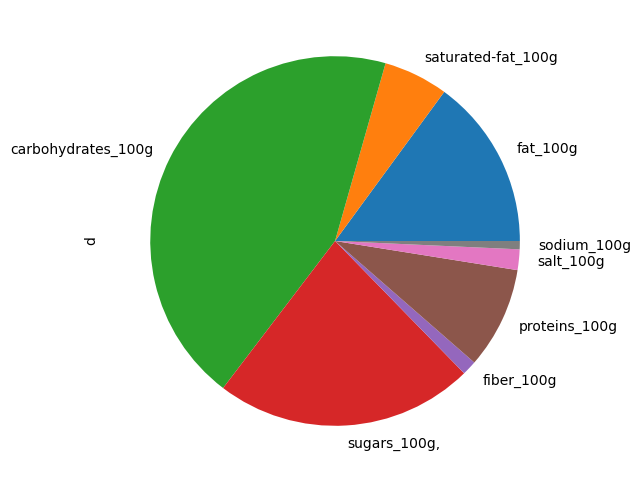

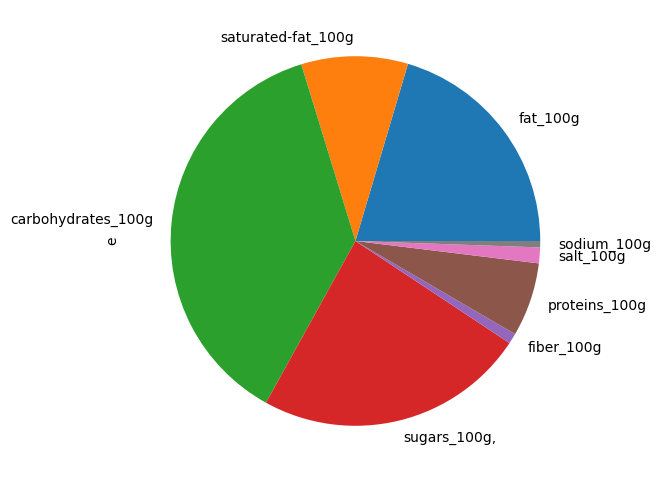

In [9]:
for fra in [scor_A, scor_B, scor_C, scor_D, scor_E]:
    moy = []
    for col in range(1, 9):
        moy.append(fra.iloc[:, col].mean())

    pie_frame = pd.Series(moy, index=['fat_100g', 'saturated-fat_100g',	'carbohydrates_100g',
                          'sugars_100g,', 'fiber_100g',	'proteins_100g', 'salt_100g', 'sodium_100g'], name=fra.iloc[1, 11])
    pie_frame.plot.pie(figsize=(6, 6))
    
    
    plt.show()

#### AutoML Tools

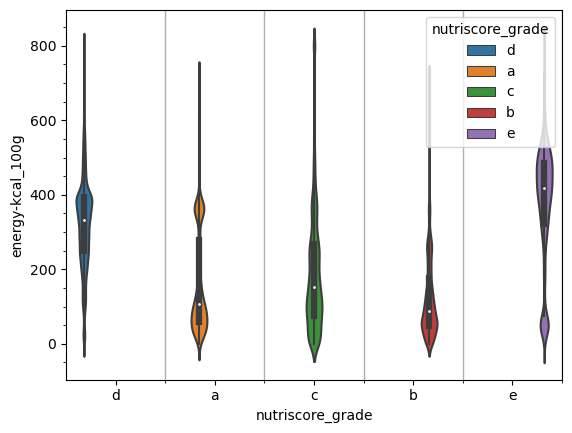

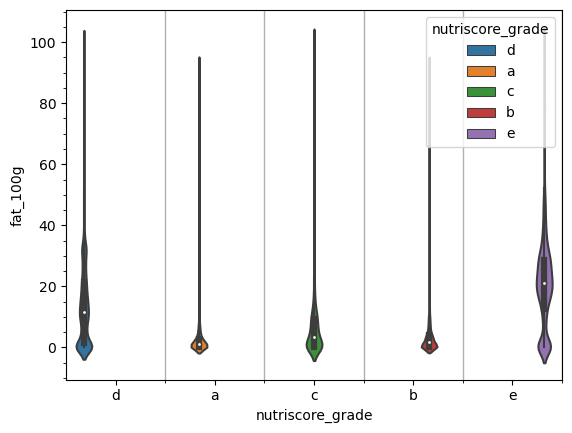

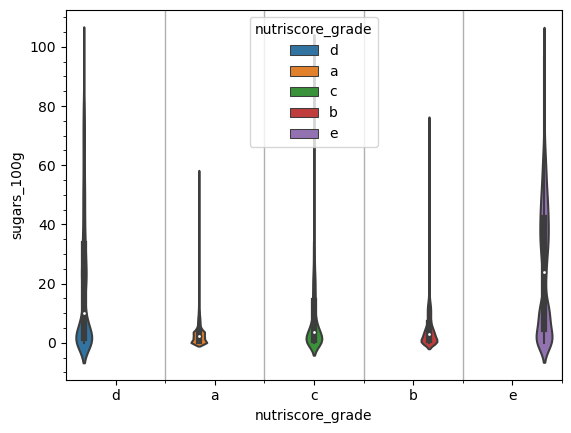

In [46]:
EDA.plot_violon_box(df=data, columns=["energy-kcal_100g", "fat_100g",
                    "sugars_100g"], x="nutriscore_grade", hue="nutriscore_grade")

#### Observons la distribution des différentes features

*TIPS: Regarder la distribution des indicateurs (ex: histo)*

##### *SOLUTION*

energy-kcal_100g


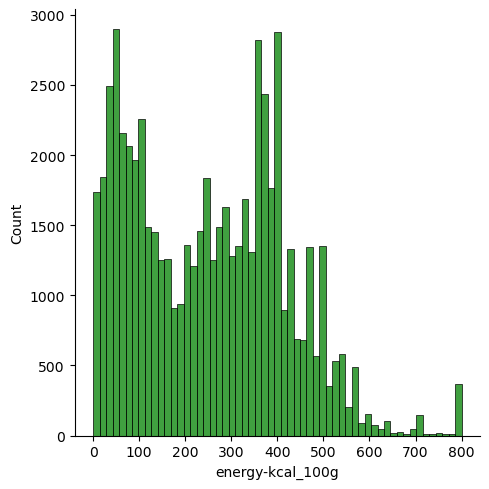

fat_100g


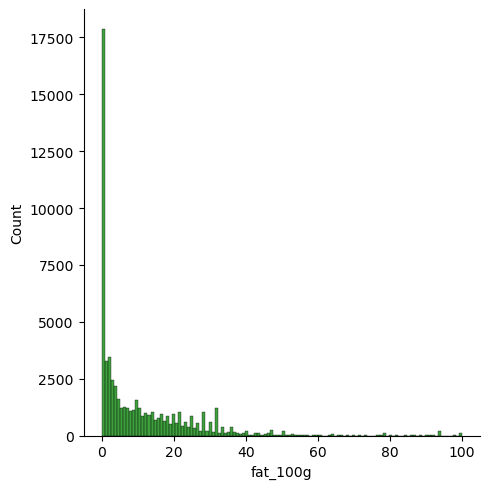

sugars_100g


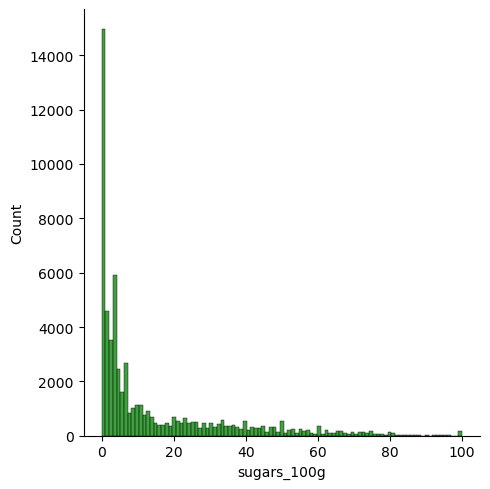

In [10]:
for cat in ["energy-kcal_100g", "fat_100g", "sugars_100g"]:
    print(cat)
    
    sns.displot(data[cat], color='green') 
    
    plt.show()

#### AutoML Tools

energy-kcal_100g


/home/jbdenis/Documents/conrad/data-science/Nutriscore/automl_script/pandas_eda.py:149: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[cat],color = 'green', rug = False, kde_kws = {'color': 'red', 'lw': 1})


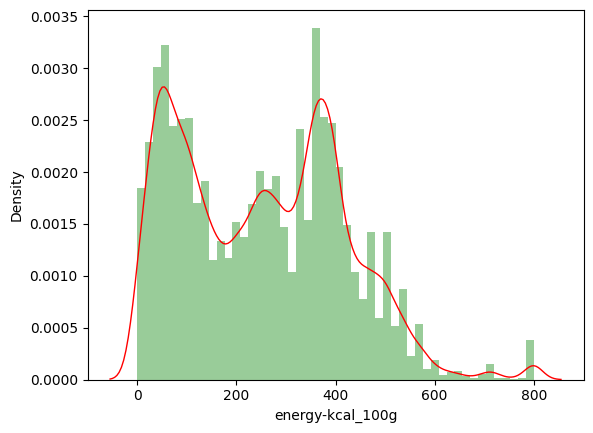

fat_100g


/home/jbdenis/Documents/conrad/data-science/Nutriscore/automl_script/pandas_eda.py:149: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[cat],color = 'green', rug = False, kde_kws = {'color': 'red', 'lw': 1})


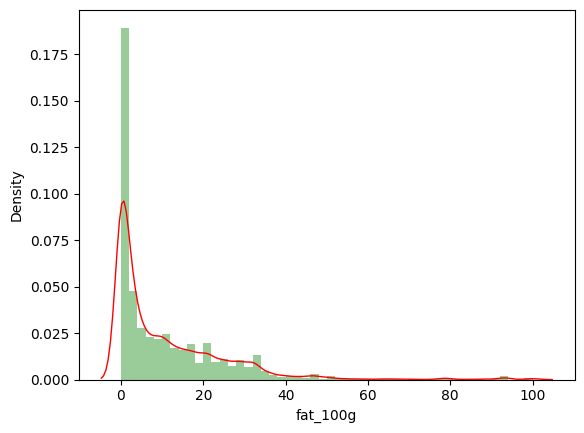

sugars_100g


/home/jbdenis/Documents/conrad/data-science/Nutriscore/automl_script/pandas_eda.py:149: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[cat],color = 'green', rug = False, kde_kws = {'color': 'red', 'lw': 1})


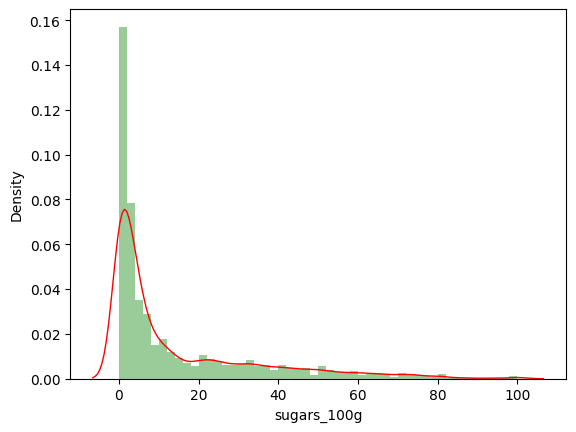

In [21]:
EDA.plot_hist_chart(df=data, columns=["energy-kcal_100g", "fat_100g", "sugars_100g"])

#### Penchons nous maintenant sur la corrélation qui peut exister entre les différentes features

*TIPS: Calculer la corrélation de Pearson des indicateurs 2 à 2*

##### *SOLUTION*

<Axes: >

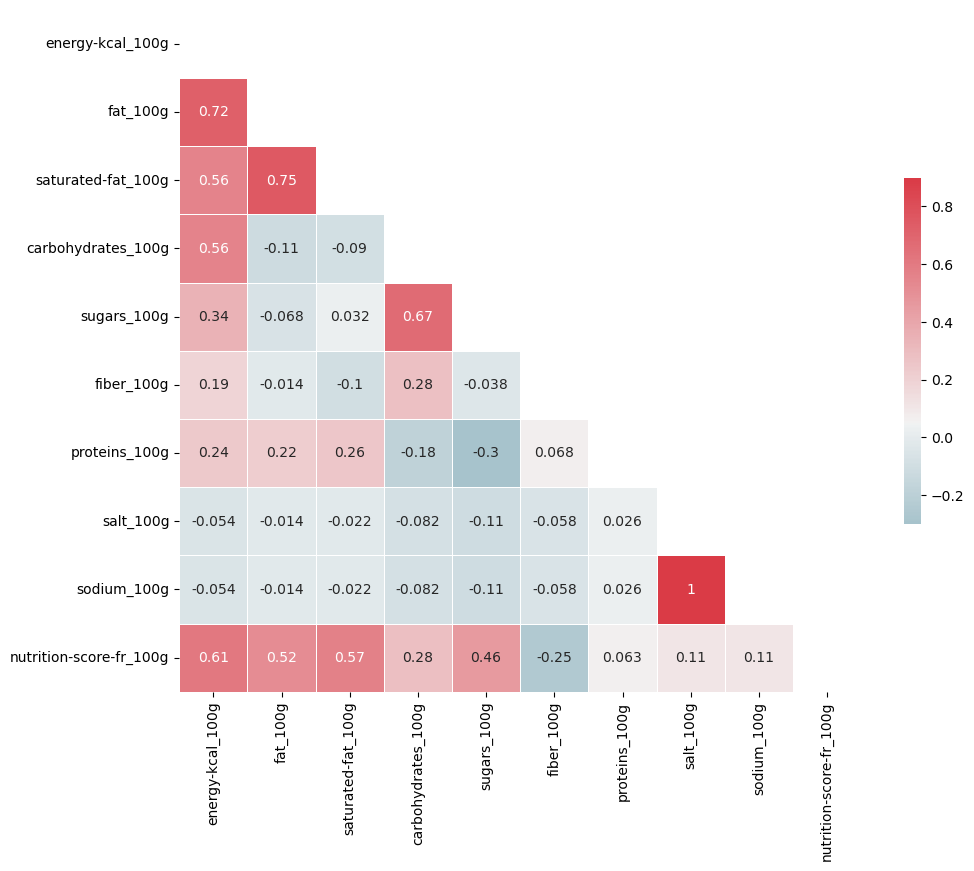

In [23]:
data_pears=data.corr(method='pearson',numeric_only=True)
#coupe en deux le heatmap
mask = np.triu(np.ones_like(data_pears, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))

# couleur
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data_pears, mask=mask, cmap=cmap, vmax=0.9, center=0.05,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

*On voit directement que certaines features sont très corrélées entre elles et portent donc une information similaire, il faudra alors **sélectionner les features** à conserver.*

#### AutoML Tools

/home/jbdenis/Documents/conrad/data-science/Nutriscore/automl_script/pandas_eda.py:143: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_pears=df.corr(method='pearson')


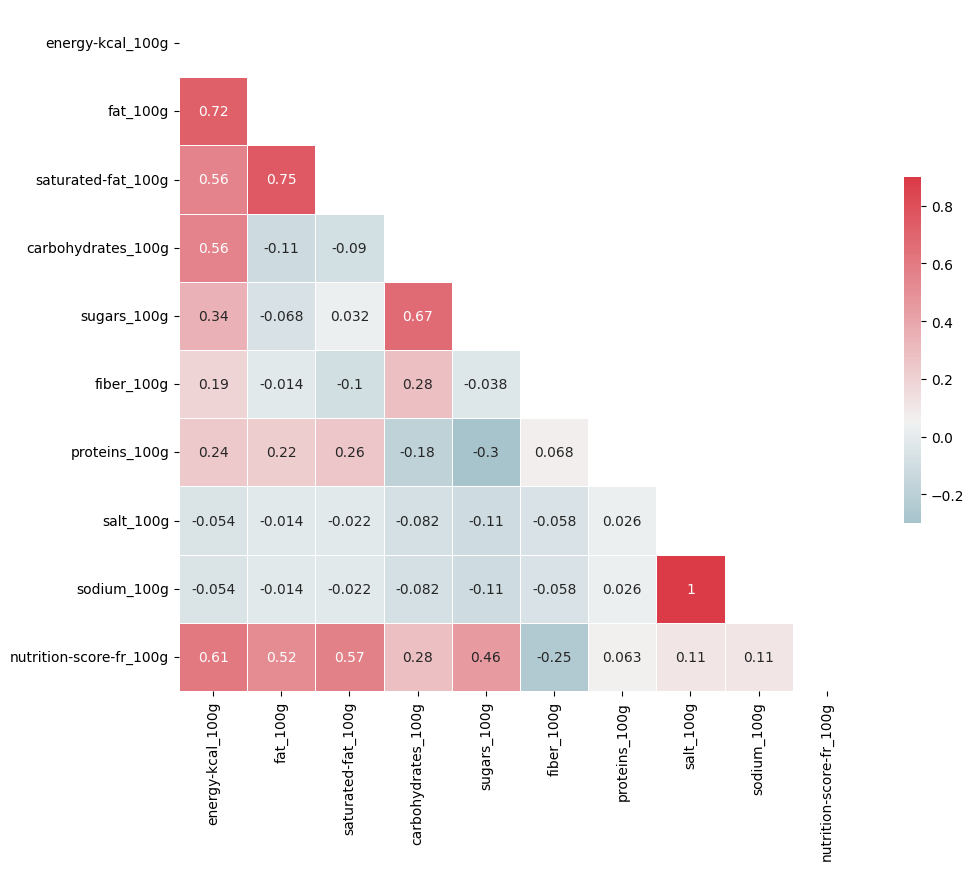

In [7]:
EDA.plot_heatmap_corr(data)

### BONUS : ACP

Il est possible d'effectuer une analyse plus poussée des informations présentes dans le dataset comme par exemple en effectuant une Analyse en Composante Principale (ACP)

(Cette partie ne sera pas abordée durant le dojo mais nous pourrons en discuter avec plaisir !! ;) )

##### *SOLUTION* (avec AutoMl Tool)

Mise à l'échelle des données

In [4]:
list_ind = ['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g','fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g']

In [5]:
SCALER = FeaturesScaler()
data_scaler = SCALER.fit_transform(data[list_ind])

scaled


Analyse en Composante Principale (ACP)

0.9739234410921879
5 composantes principales expliquent au moins 95% de la variance totale
nb composantes principale 5
ACP analyse started


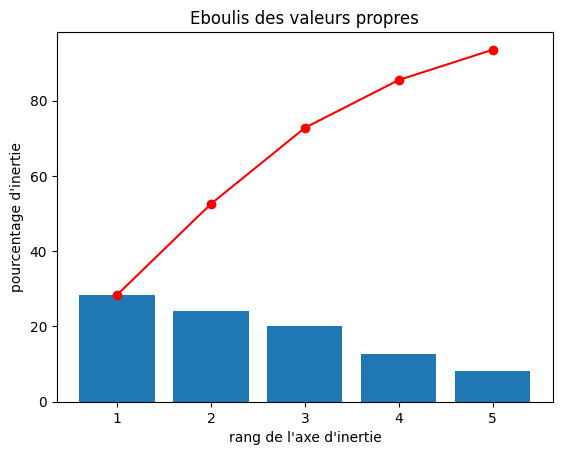

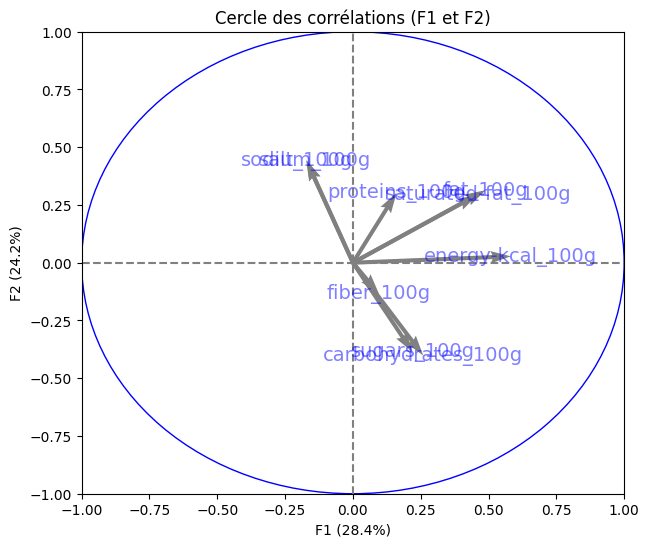

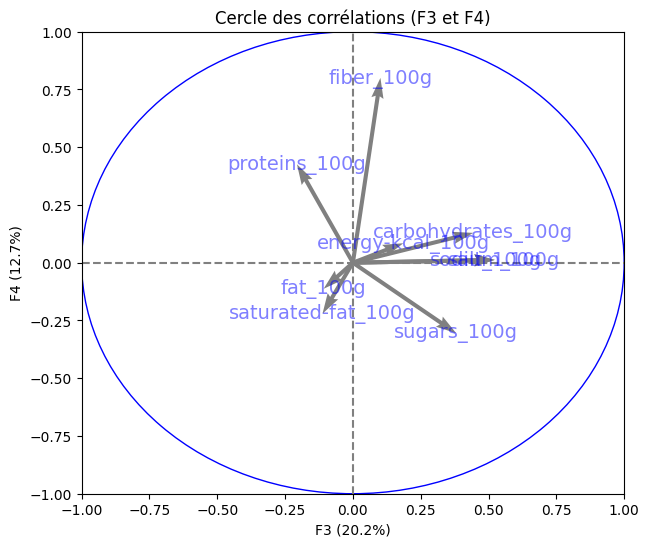

F1
[ 0.58227239  0.48916858  0.46050295  0.25934169  0.22008365  0.09604177
  0.16090917 -0.17146309 -0.17146339]
F2
[ 0.02753948  0.31412546  0.29500963 -0.4017824  -0.38693353 -0.13439859
  0.30257089  0.44315771  0.44315748]
F3
[ 0.18589719 -0.10786714 -0.11202047  0.44366727  0.38063758  0.10151427
 -0.20622296  0.52282863  0.52282873]
F4
[ 0.08433703 -0.11277859 -0.2205941   0.12922763 -0.30477768  0.80008896
  0.42600172  0.01219561  0.01219571]


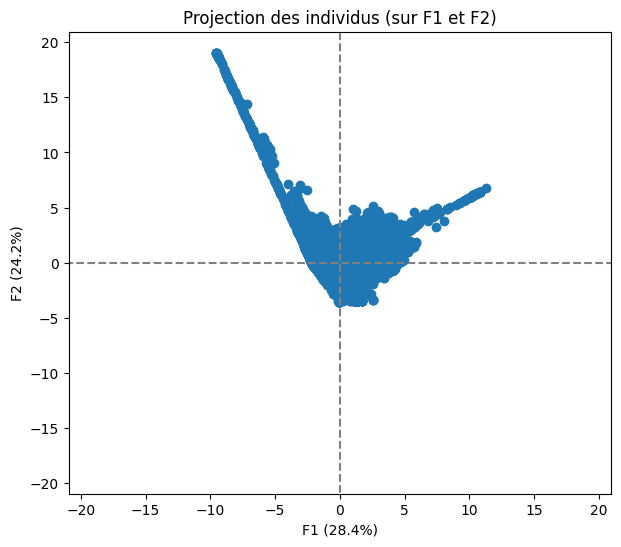

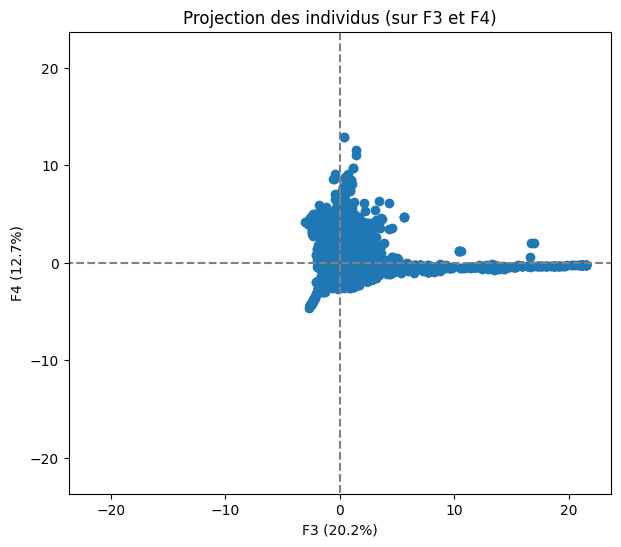

ACP done


In [6]:
ACP=AcpReduction(analyse=True, columns=list_ind)
data_reduc = ACP.fit_transform(data_scaler)

In [10]:
data_ACP = pd.DataFrame(data_reduc, index= data.index, columns= ["F"+str(i+1) for i in range(5)])
data_ACP['nutriscore_grade']=data['nutriscore_grade']
data_ACP.head()

F1        F2        F3        F4        F5 nutriscore_grade
0  5.153071  2.809091 -1.218180 -1.644528 -2.667370                d
1 -0.111599 -0.317733 -0.210501 -0.966492 -0.043964                d
2  0.090960  0.702577 -0.474705 -0.029939  0.303362                d
3 -0.149737  1.419798 -0.987696  0.030498  0.949173                d
4  0.353928 -0.001021 -0.399908 -1.083494 -0.092044                d

# Attribuons maintenant un nutriscore à un aliment grâce au machine learning

## Comment faire pour avoir un modèle qui marche ?!

**Déjà, qu'est ce qu'un modèle... ?**

Un modèle de machine learning est essentiellement un algorithme capable d'apprendre à partir de données et de faire des prédictions ou de prendre des décisions sur la base de cet apprentissage. 

Sa construction implique de fournir au modèle un grand nombre d'exemples de données.

Une fois entraîné, il peut être utilisé pour effectuer des tâches spécifiques comme de la classification, de la prédiction, du clustering, etc.

Voici une illustration de la trame du travail d'un Data Scientist.

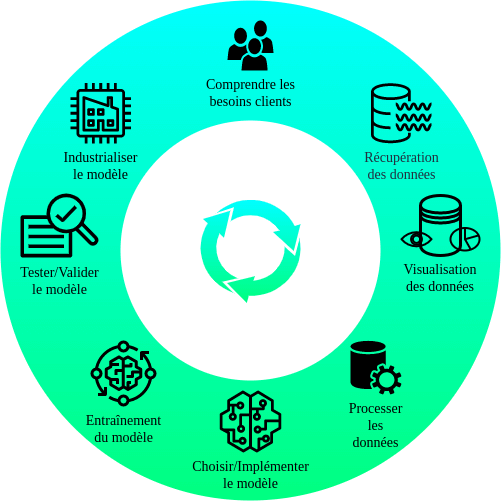

Voir : https://kaizen-solutions.net/kaizen-insights/articles-et-conseils-de-nos-experts/cycle-de-vie-projet-machine-learning-8-etapes/

**Sup. VS non Sup.**

- Les modèles supervisés sont des modèles qui apprennent à partir d'un ensemble de données étiquetées, c'est-à-dire des données pour lesquelles la réponse attendue est déjà connue. L'objectif de ce modèle est de généraliser un comportement à partir d'exemples pour être capable de prédire les étiquettes de nouvelles données non étiquetées. Pour cette famille de modèle il faudra également optimiser des hyper paramètres pour affiner les résultats de l'apprentissage. Ces modèles sont utilisés pour des opérations de prédiction ou de classification.

- Les modèles non supervisés, en revanche, apprennent à partir de données non étiquetées, c'est-à-dire des données pour lesquelles les étiquettes ou les catégories ne sont pas disponibles. Le modèle recherche des structures, des relations ou des schémas intrinsèques dans les données sans aucune indication préalable sur les catégories. Ces modèles sont utilisés pour de la clusterisation.

**Pipeline de construction d'un modèle**

Un modèle de machine learning se construit suivant plusieurs étapes:

- Analyse des données
- Feature engineering (Feature selection, scaling, sampling)
- Split du Data set
- Sélection du modèle
- Mise en place de l'optimisation des HP (ex: GridSearch)
- Choix de la métrique de scoring
- Entraînement du modèle (via une Cross Validation par ex.)
- Analyse des résulats (ex: Feature importances)
- Test du modèle

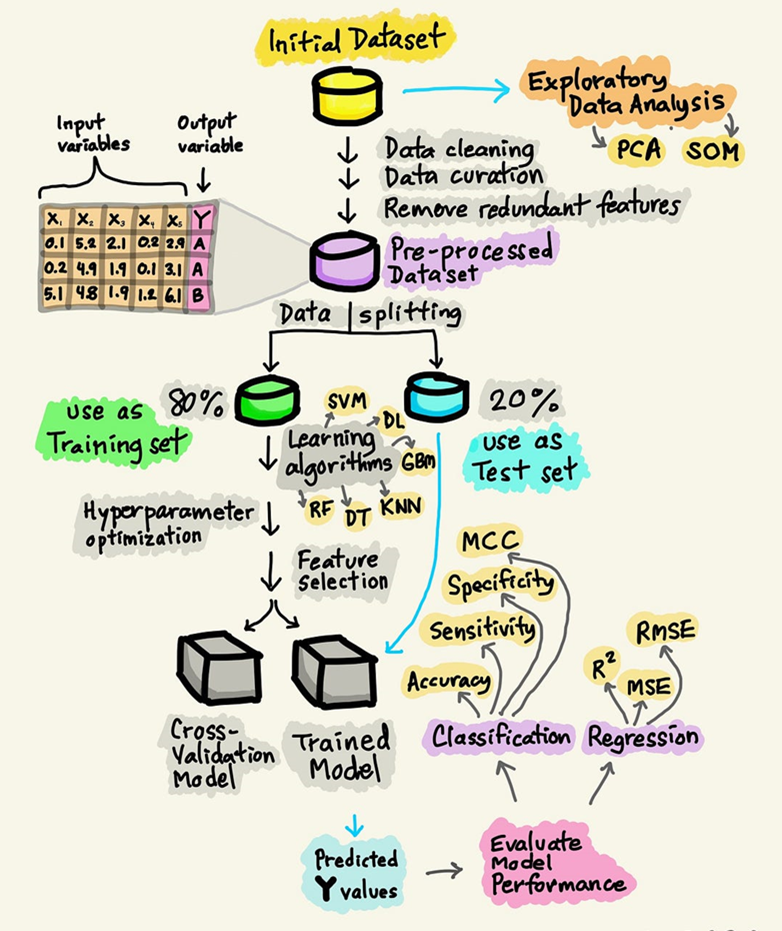

## Chargement des jeux de données d'entrainement et de test

In [24]:
data_train=pd.read_csv("train_data_clean.csv",sep = '\t',low_memory=False).drop('Unnamed: 0',axis=1)
data_test=pd.read_csv("test_data_clean.csv",sep = '\t',low_memory=False).drop('Unnamed: 0',axis=1)

Pour gagner du temps prenons chacun un échantillon du dataset d'entrainement
(Choisissez un random_state différent)

*TIPS: Choisissez une valeur pour le random_state*

In [25]:
data_train_sample = data_train.sample(n=1000, random_state=42)
print(data_train_sample.shape)

(1000, 12)


## Feature Engeneering

#### Commençons par sélectionner les features qui nous intéressent

In [26]:
list_ind = ['energy-kcal_100g', 'fat_100g', 'carbohydrates_100g',
              'fiber_100g',	'proteins_100g', 'salt_100g']

#### Ensuite splittons nos données en set de train et de test

*TIPS: Utiliser la fonction train_test_split() de Scikit learn*

##### *SOLUTION*

In [27]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_train_sample[list_ind],
                                                    data_train_sample["nutriscore_grade"],
                                                    test_size=0.2, 
                                                    random_state=42)

#### Maintenant mettons à l'échelle nos données.

*TIPS: Utiliser la fonction StandardScaler() de Scikit learn*

##### *SOLUTION*

In [28]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Nous allons maintenant travailler sur le déséquilibre du nutri-score avec de "l'Under Sampling"

*TIPS: Utiliser la fonction RandomUnderSampler() de imblearn*

##### *SOLUTION*

In [29]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[('a', 114), ('b', 114), ('c', 114), ('d', 114), ('e', 114)]


## Training

### Le modèle K-Nearest-Neighbors (KNN)

Le KNN est un algorithme basé sur le calcul de similarité entre les données. Pour cela il va calculer les distances, euclidiennes par exemple, entre un input et ses K voisins les plus proches. 

Plus les distances entre les input sont faibles, plus ces derniers sont considérés comme similaires. 

Pour une classification, un "vote" majoritaire en fonction de ce calcul de distance permettra d'attribuer une étiquette.

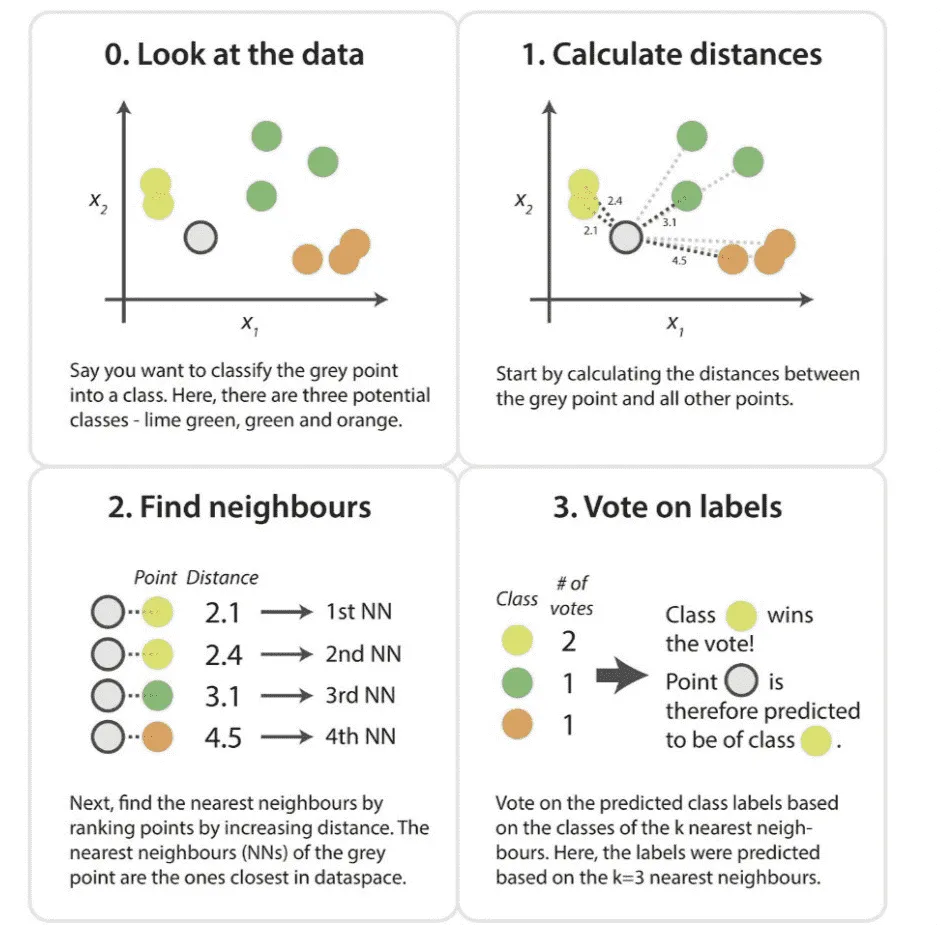

Pour plus d'informations: https://medium.com/swlh/k-nearest-neighbor-ca2593d7a3c4

#### Cherchons quel est le nombre de voisins à considérer pour obtenir les meilleurs résultats.

*TIPS: Mettre en place une boucle sur l'entrainement du modèle pour trouver le bon nombre de voisins*

Voir : https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

Voir : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

##### *SOLUTION*

In [30]:
list_voisin = range(3,33,3)
acc_list = []
prec_list =[]
recal_list = []

for v in list_voisin:
  
  knn_classification = KNeighborsClassifier(n_neighbors=v)
  knn_classification.fit(X_resampled, y_resampled)
  
  pred = knn_classification.predict(X_test)
  
  acc_list.append(accuracy_score(y_test, pred))
  f_resulte = precision_recall_fscore_support(
      y_test, pred, average="macro")
  prec_list.append(f_resulte[0])
  recal_list.append(f_resulte[1])  
  
frame_erreur_knn=pd.DataFrame() 
frame_erreur_knn['nb_voisin']=list_voisin
frame_erreur_knn["accuracy"] = acc_list
frame_erreur_knn["precision"] = prec_list
frame_erreur_knn["recall"] = recal_list
  
frame_erreur_knn

nb_voisin  accuracy  precision    recall
0          3     0.620   0.615402  0.650554
1          6     0.620   0.622653  0.647208
2          9     0.610   0.613293  0.647363
3         12     0.595   0.598387  0.631257
4         15     0.575   0.575517  0.603999
5         18     0.565   0.567056  0.591096
6         21     0.545   0.548727  0.574887
7         24     0.550   0.553812  0.578515
8         27     0.540   0.542777  0.564315
9         30     0.545   0.542376  0.571195

<Axes: xlabel='nb_voisin'>

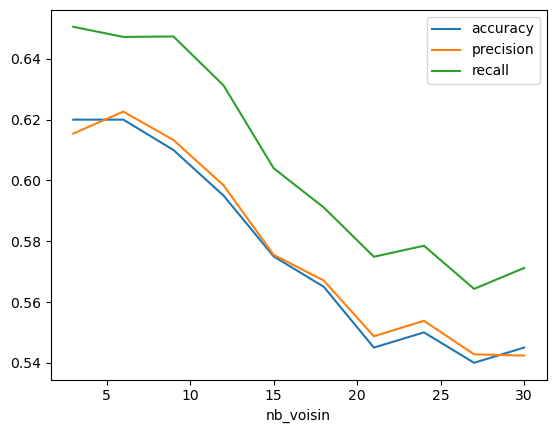

In [31]:
frame_erreur_knn.plot('nb_voisin',['accuracy','precision','recall'])

- Accuracy mesure la proportion d'inputs correctement classés parmi tous les inputs. 

- Precision mesure la proportion d'inputs positifs correctement classés parmi tous les inputs prédits comme positifs. 

- Recall mesure la proportion d'inputs positifs correctement classés parmi tous les inputs réellement positifs. 

*On voit ici que le nombre de voisins permettant d'avoir les meilleurs résultats est entre 3 et 6.*

### Automatisons l'optimisation des HP avec une GridSearch en Cross Validation

#### La RandomForest

Une Random Forest est un ensemble d'arbres de décision qui effectue une classification en combinant les prédictions de chaque arbre par vote majoritaire.

Chaque arbre décisionnel effectue un apprentissage sur des sous-ensembles de données légèrement différents.

Cela correspond au principe du bagging, qui vient instaurer de l’aléatoire dans le jeux de données permettant d'éviter un sur-apprentissage.  


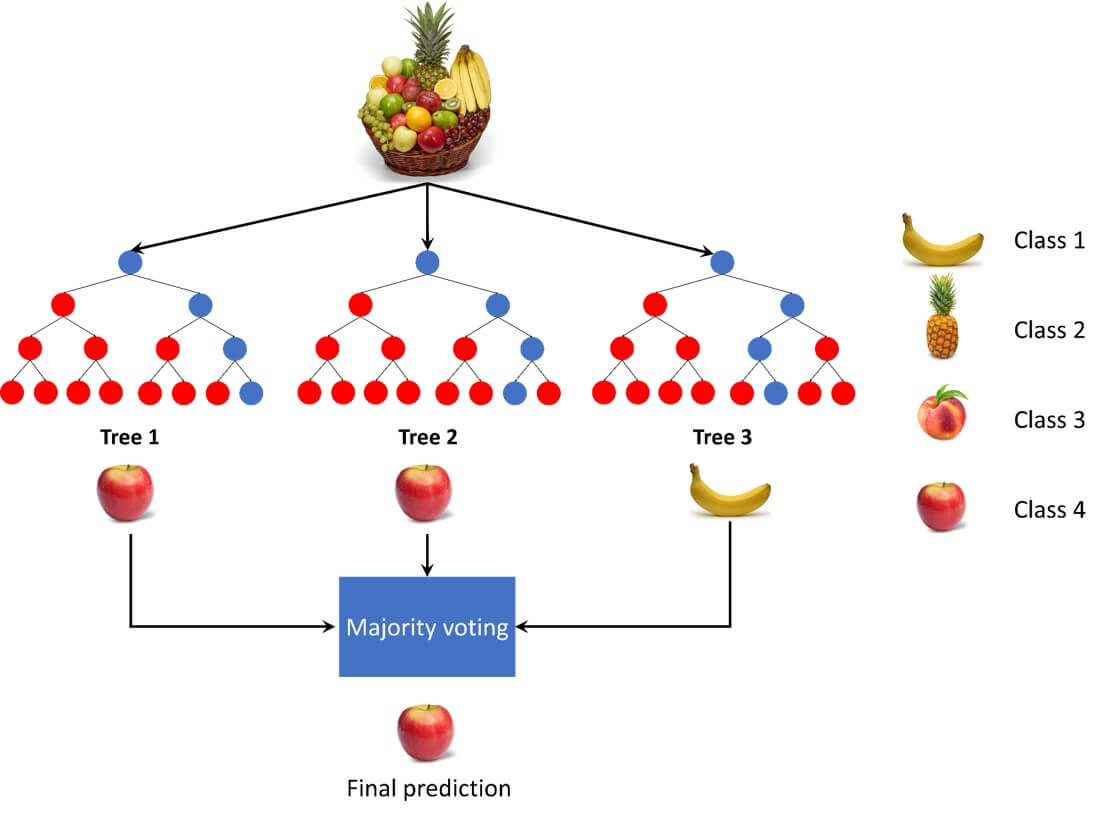

Plus d'information : https://careerfoundry.com/en/blog/data-analytics/what-is-random-forest/#:~:text=Random%20Forest%20is%20used%20for,to%20name%20just%20a%20few!

#### Mettons en place la GridSearch en Cross Validation pour optimiser les Hyper Paramètres

**C'est quoi un HP ?**

Les hyper paramètres sont les paramètres du modèle qui ne sont pas appris pendant l'entraînement, mais qui influencent les performances de ce dernier, tels que la profondeur maximale d'un arbre de décision ou le nombre de voisins dans un KNN.

**Et une GridSearch ?**

Une GridSearch est une méthode systématique qui permet d'optimiser les hyper paramètres d'un modèle supervisé.

Elle consiste à définir une grille de toutes les combinaisons possibles, optimisées selon les valeurs des hyper paramètres. 

**Et une Cross Validation ?** 

La validation croisée est une technique d'évaluation des performances d'un modèle. 

Elle consiste à diviser les données en sous-ensembles, et à entraîner le modèle sur ces différents sets. 

Les performances obtenues sont agrégées pour obtenir une estimation fiable des performances du modèle. 

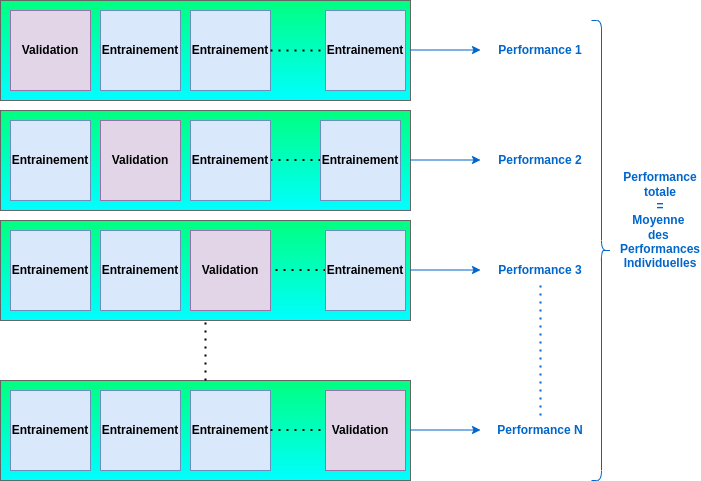

#### Appliquons ces méthodes à la RandomForest

*TIPS: Utiliser la fonction GridSearchCV() de Scitkit learn* 

Voir https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

##### *SOLUTION*

In [32]:
# Model
estimator = RandomForestClassifier()

# Hyper parameters
space = {'max_depth': [10, 20, 50],
         'min_samples_leaf': [5, 10, 20]
         }

# Score
score = "accuracy"

# Number of cross validation
cv = 5

In [33]:
model_CV = GridSearchCV(estimator=estimator,
                        param_grid=space,
                        scoring=score,
                        cv=cv,
                        error_score='raise',
                        verbose=2)

model_CV.fit(X_resampled, y_resampled)

# Best parameter
print("Best parameter:", model_CV.best_params_)
# Best score
print("Best accuracy score:", model_CV.best_score_*100)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ...................max_depth=10, min_samples_leaf=5; total time=   0.1s
[CV] END ...................max_depth=10, min_samples_leaf=5; total time=   0.1s
[CV] END ...................max_depth=10, min_samples_leaf=5; total time=   0.1s
[CV] END ...................max_depth=10, min_samples_leaf=5; total time=   0.1s
[CV] END ...................max_depth=10, min_samples_leaf=5; total time=   0.1s
[CV] END ..................max_depth=10, min_samples_leaf=10; total time=   0.1s
[CV] END ..................max_depth=10, min_samples_leaf=10; total time=   0.1s
[CV] END ..................max_depth=10, min_samples_leaf=10; total time=   0.1s
[CV] END ..................max_depth=10, min_samples_leaf=10; total time=   0.1s
[CV] END ..................max_depth=10, min_samples_leaf=10; total time=   0.1s
[CV] END ..................max_depth=10, min_samples_leaf=20; total time=   0.1s
[CV] END ..................max_depth=10, min_samp

#### Regardons le poids de chaque feature dans l'entrainement du modèle

*TIPS: Utiliser best_estimator_.feature_importances_ pour obtenir l'importance des différentes features*

##### *SOLUTION*

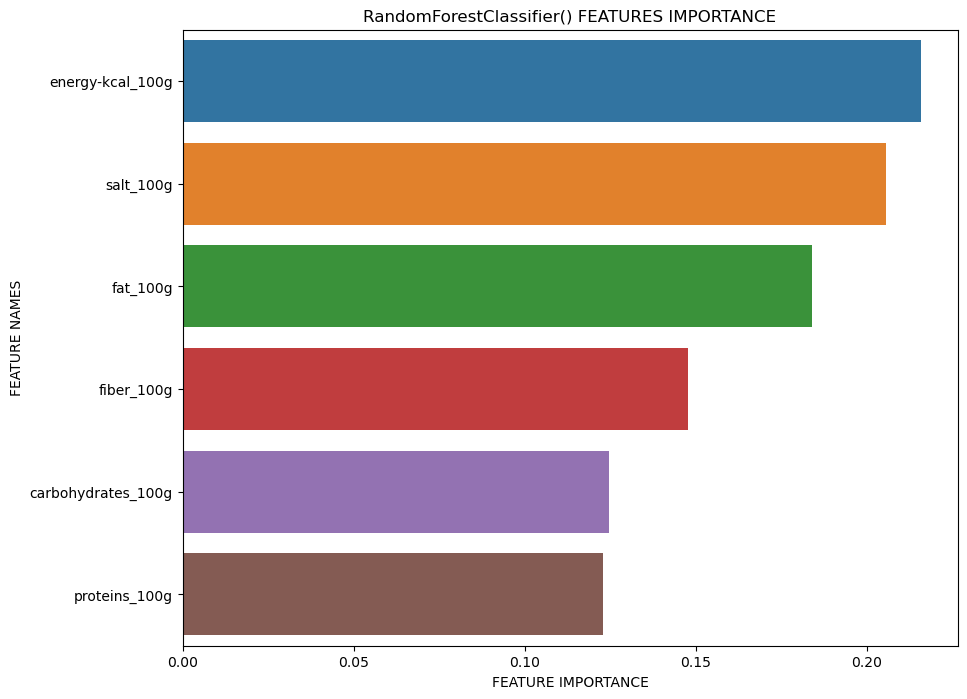

In [34]:
importance = model_CV.best_estimator_.feature_importances_
feature_importance = np.array(importance)
feature_names = np.array(list_ind)
data_ft = {'feature_names': feature_names,
        'feature_importance': feature_importance}
fi_df = pd.DataFrame(data_ft)
fi_df.sort_values(by=['feature_importance'],
                    ascending=False, inplace=True)

df_10 = fi_df.head(10)  
fig = plt.figure(figsize=(10, 8))
sns.barplot(x=df_10['feature_importance'], y=df_10['feature_names'])
plt.title(f"{estimator} FEATURES IMPORTANCE")
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')
plt.show()

#### Vérifions la fiabilité de notre modèle sur le jeu de test

##### *SOLUTION*

In [35]:
y_pred = model_CV.predict(X_test)

In [36]:
print("Accuracy: ", accuracy_score(y_test, y_pred))
f_resulte = precision_recall_fscore_support(
      y_test, y_pred, average="macro")
print("Precision: ", f_resulte[0])
print("Recall: ", f_resulte[1]) 

Accuracy:  0.695
Precision:  0.681066404445201
Recall:  0.696054111888628


#### Regardons les résultats sur une matrice de confusion

*TIPS: Utiliser ConfusionMatrixDisplay de Scikit learn*

Voir : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

##### *SOLUTION*

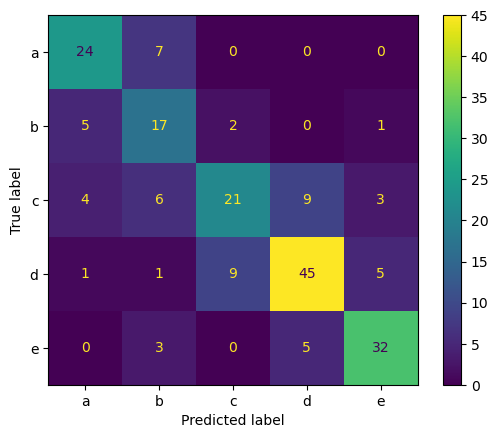

In [37]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

#### AutoML Tools

Entraînement des modèles supervisés

In [5]:
list_ind = ['energy-kcal_100g', 'fat_100g', 'carbohydrates_100g',
              'fiber_100g',	'proteins_100g', 'salt_100g']

SCALER = FeaturesScaler()

# Train
data_train_scal = pd.DataFrame(SCALER.fit_transform(data_train[list_ind]),columns=list_ind)
data_train_scal['nutrition-score']=data_train["nutriscore_grade"]
data_train_scal.head()

scaled


energy-kcal_100g  fat_100g  carbohydrates_100g  fiber_100g  proteins_100g  \
0          3.303608  6.217111           -1.119842   -0.699649      -0.881508   
1         -0.277103 -0.133265           -0.096532   -0.699649      -0.512027   
2          0.065114  0.167609           -0.256239   -0.383536       0.494619   
3         -0.132428  0.297151           -0.980664   -0.699649       1.380619   
4         -0.138456  0.247702           -0.324437   -0.699649      -0.342368   

   salt_100g nutrition-score  
0  -0.304187               d  
1  -0.240217               d  
2   0.037541               d  
3   0.129505               d  
4  -0.273286               d

In [6]:
SUPMLENGINE = SupMLEngine()

Cv for model: KNeighborsClassifier()
{'leaf_size': [1, 5, 10], 'n_neighbors': [5, 10], 'p': [1, 2]}
split done
GridSearchCV(cv=5, error_score='raise', estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 5, 10], 'n_neighbors': [5, 10],
                         'p': [1, 2]},
             scoring='accuracy', verbose=2)
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ....................leaf_size=1, n_neighbors=5, p=1; total time=   0.7s
[CV] END ....................leaf_size=1, n_neighbors=5, p=1; total time=   0.8s
[CV] END ....................leaf_size=1, n_neighbors=5, p=1; total time=   0.7s
[CV] END ....................leaf_size=1, n_neighbors=5, p=1; total time=   0.7s
[CV] END ....................leaf_size=1, n_neighbors=5, p=1; total time=   0.7s
[CV] END ....................leaf_size=1, n_neighbors=5, p=2; total time=   0.6s
[CV] END ....................leaf_size=1, n_neighbors=5, p=2; total time=   0.5s
[CV] END ....................l

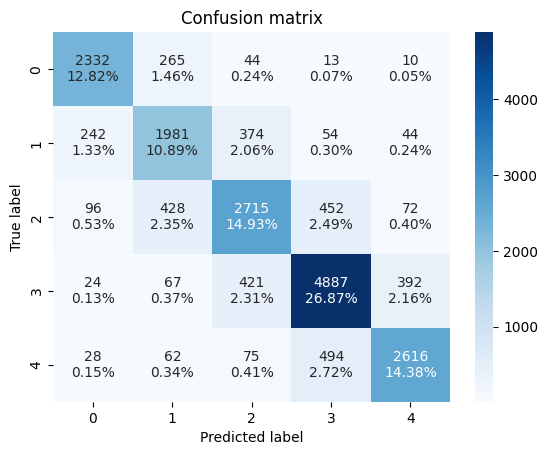

{'accuracy': 0.7989333626566967, 'precision': 0.7949253718948267, 'recall': 0.7949226881529248, 'f0.5_score': 0.7988769540834734, 'f1_score': 0.794706415759427, 'f2_score': 0.7988237655891077}
error during feat importance plot 'KNeighborsClassifier' object has no attribute 'feature_importances_'
---------------------------------------------
Done
---------------------------------------------
Cv for model: RandomForestClassifier()
{'max_depth': [10, 20, 50], 'min_samples_leaf': [5, 10, 20], 'max_features': ['sqrt', 'auto']}
split done
GridSearchCV(cv=5, error_score='raise', estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20, 50],
                         'max_features': ['sqrt', 'auto'],
                         'min_samples_leaf': [5, 10, 20]},
             scoring='accuracy', verbose=2)
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5; total time=   2.8s
[CV] END max_depth=10, max_fe

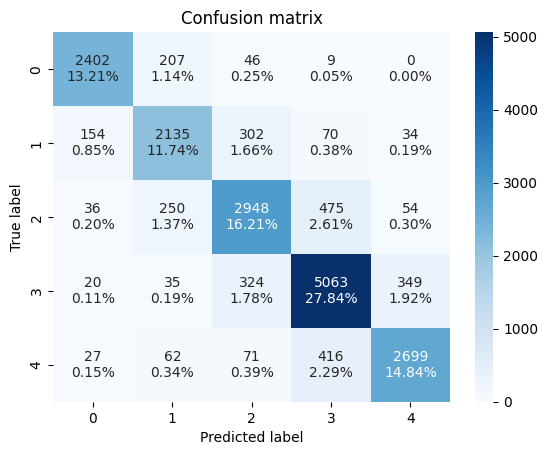

{'accuracy': 0.8382999780074775, 'precision': 0.840547279307664, 'recall': 0.835137351020758, 'f0.5_score': 0.8382385090932071, 'f1_score': 0.8376723538127898, 'f2_score': 0.8381864033148042}


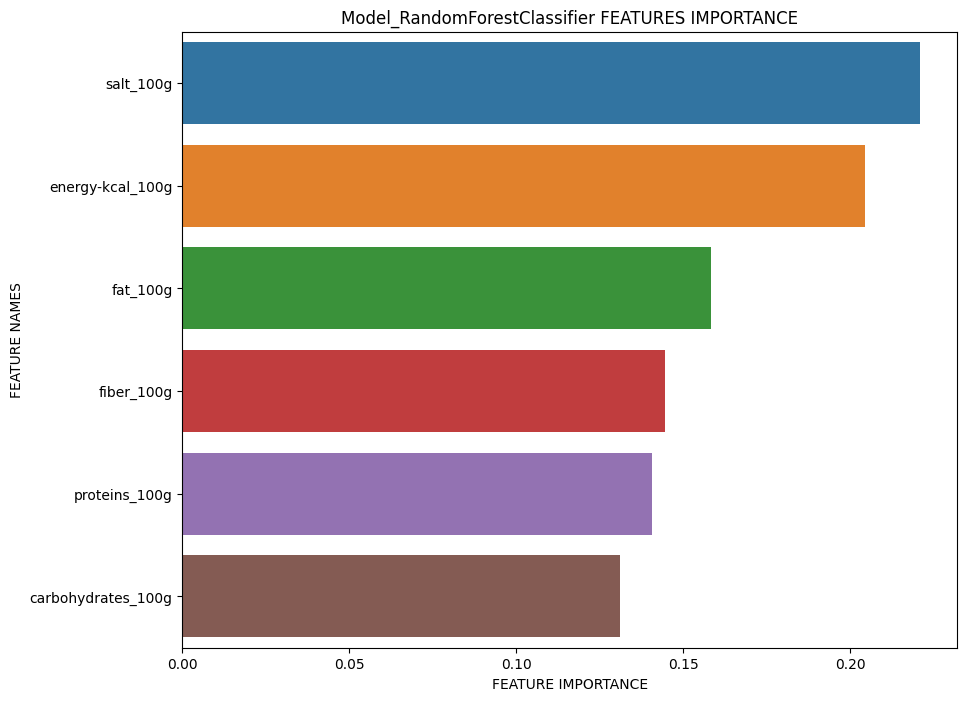

---------------------------------------------
Done
---------------------------------------------
Cv for model: SVC(probability=True)
{'gamma': array([0.01, 0.1 , 1.  ]), 'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])}
split done
GridSearchCV(cv=5, error_score='raise', estimator=SVC(probability=True),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'gamma': array([0.01, 0.1 , 1.  ])},
             scoring='accuracy', verbose=2)
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END .................................C=0.01, gamma=0.01; total time= 5.2min
[CV] END .................................C=0.01, gamma=0.01; total time= 5.5min
[CV] END .................................C=0.01, gamma=0.01; total time= 5.1min
[CV] END .................................C=0.01, gamma=0.01; total time= 4.9min
[CV] END .................................C=0.01, gamma=0.01; total time= 4.9min
[CV] END ................................

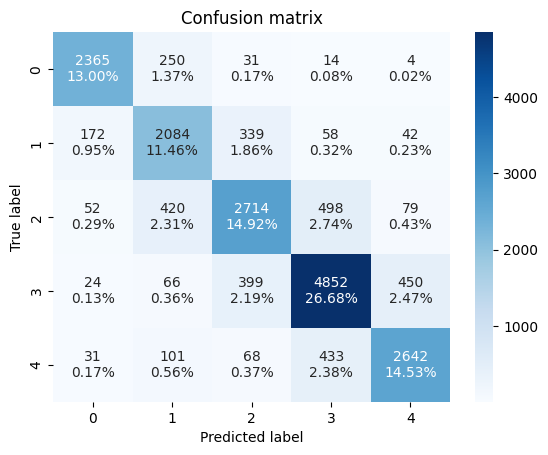

{'accuracy': 0.8058610072575324, 'precision': 0.8044359157249046, 'recall': 0.8053698153606328, 'f0.5_score': 0.806235542583487, 'f1_score': 0.8045167332632246, 'f2_score': 0.8057950086250998}
error during feat importance plot 'SVC' object has no attribute 'feature_importances_'
---------------------------------------------
Done
---------------------------------------------
Cv for model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monoton

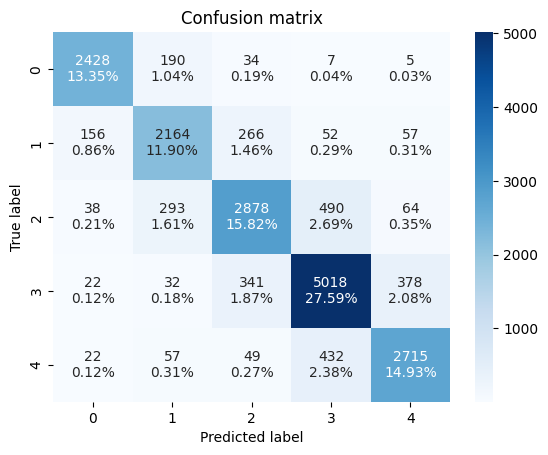

{'accuracy': 0.8358808005278205, 'precision': 0.8376360172403091, 'recall': 0.8349439642397206, 'f0.5_score': 0.835577681514731, 'f1_score': 0.8361042575064885, 'f2_score': 0.8357014533391032}


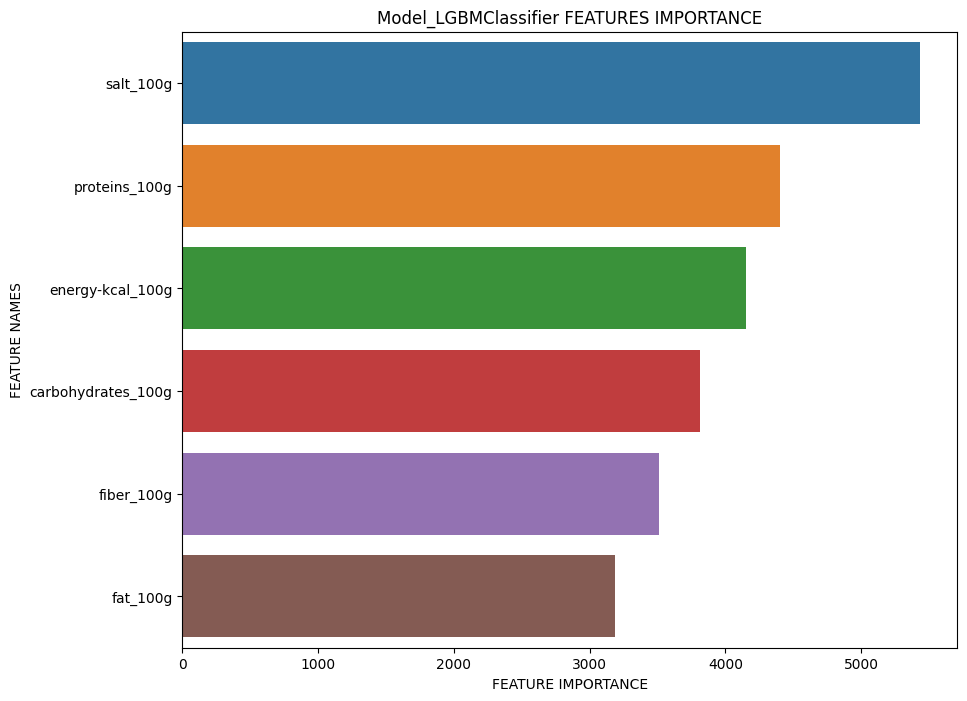

---------------------------------------------
Done
---------------------------------------------
---------------------------------------------
Resume:  {KNeighborsClassifier(): (KNeighborsClassifier(leaf_size=1, p=1), {'leaf_size': 1, 'n_neighbors': 5, 'p': 1}, {'accuracy': 0.7989333626566967, 'precision': 0.7949253718948267, 'recall': 0.7949226881529248, 'f0.5_score': 0.7988769540834734, 'f1_score': 0.794706415759427, 'f2_score': 0.7988237655891077}), RandomForestClassifier(): (RandomForestClassifier(max_depth=50, min_samples_leaf=5), {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 5}, {'accuracy': 0.8382999780074775, 'precision': 0.840547279307664, 'recall': 0.835137351020758, 'f0.5_score': 0.8382385090932071, 'f1_score': 0.8376723538127898, 'f2_score': 0.8381864033148042}), SVC(probability=True): (SVC(C=100.0, gamma=1.0, probability=True), {'C': 100.0, 'gamma': 1.0}, {'accuracy': 0.8058610072575324, 'precision': 0.8044359157249046, 'recall': 0.8053698153606328, 'f0.5_s

In [19]:
models = ["KNN", "RFC", "SVClass", "XGB", "LGBM"]

SUPMLENGINE = SupMLEngine()

result_scor = SUPMLENGINE.start_ml(supervised_type="cla",
                                   feature_names=list_ind,
                                   features=data_train_scal[list_ind],
                                   target=data_train_scal["nutrition-score"],
                                   models=models,
                                   ratio_split=0.3,
                                   nb_cv=5)

In [21]:
df_result = SUPMLENGINE.show_ml_result(dic_estimator=result_scor)
df_result

model                                         parametres  \
0    KNeighborsClassifier         {'leaf_size': 1, 'n_neighbors': 5, 'p': 1}   
1  RandomForestClassifier  {'max_depth': 50, 'max_features': 'sqrt', 'min...   
2                     SVC                         {'C': 100.0, 'gamma': 1.0}   
3           XGBClassifier                         {'C': 100.0, 'gamma': 1.0}   
4          LGBMClassifier  {'min_child_samples': 10, 'min_child_weight': ...   

   accuracy  precision    recall  f0.5_score  f1_score  f2_score  
0  0.798933   0.794925  0.794923    0.798877  0.794706  0.798824  
1  0.838300   0.840547  0.835137    0.838239  0.837672  0.838186  
2  0.805861   0.804436  0.805370    0.806236  0.804517  0.805795  
3  0.805861   0.804436  0.805370    0.806236  0.804517  0.805795  
4  0.835881   0.837636  0.834944    0.835578  0.836104  0.835701

In [20]:
import pickle

pickle.dump(result_scor, open("result_scor_clavf.p", "wb"))

# Classifiez votre produit !!!

In [39]:
#fonction modélisation nutrition grade
def modelisation_nutrition_grade(scaler, model):
    
  #Récupération des valeurs d'entrée
  NAME=input('Nom du produit :')
  NRJ=input('Energie (kcal pour 100g) :')
  GRAS=input('Gras (g pour 100g) :')
  SUCRE=input('Sucre (g pour 100g) :')
  FIBRE=input('Fibre (g pour 100g) :')
  PROT=input('Protéines (g pour 100g) :')
  SEL= input('Sel (g pour 100g) :')
 
  list_input =[NRJ,GRAS,SUCRE,FIBRE,PROT,SEL]
  list_input_i=[]
 
  for i in list_input:
 
    if i != '':
      list_input_i.append(float(i))
    elif i == '':
      list_input_i.append(np.NaN)
 
  #Formatage de l'entrée
  colon_name=['energy-kcal_100g', 'fat_100g', 'carbohydrates_100g', 'fiber_100g', 'proteins_100g', 'salt_100g']
  data_input=pd.DataFrame([list_input_i],columns=colon_name)
 
  X_scaled = scaler.transform(data_input)

  Y_pred = model.predict(X_scaled)

  #Formatage du set
  scor_mod=Y_pred
  data_output=pd.DataFrame()
  data_output['nutritionscore_mod']=scor_mod
  data_output['product_name']=NAME
  data_output=data_output.set_index(data_output['product_name'])
  data_output=data_output.drop(['product_name'],axis=1)
 
  return data_output

In [42]:
modelisation_nutrition_grade(scaler=scaler,
                             model=model_CV)

Nom du produit : Nesquik
Energie (kcal pour 100g) : 407
Gras (g pour 100g) : 12.9
Sucre (g pour 100g) : 60.7
Fibre (g pour 100g) : 4.9
Protéines (g pour 100g) : 7
Sel (g pour 100g) : 0.49


nutritionscore_mod
product_name                   
Nesquik                       d

### AutoML Tools

In [43]:
import pickle
result_scor = pickle.load(open("result_scor_clavf.p", "rb"))

ls_model = []
for model, it in result_scor.items():
    ls_model.append(it[0])

ls_model[1]

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at

RandomForestClassifier(max_depth=50, min_samples_leaf=5)

In [ ]:
# Test
data_test_scal = pd.DataFrame(SCALER.transform(data_test[list_ind]),columns=list_ind)
data_test_scal['nutrition-score']=data_test['nutriscore_grade']

data_test_sample = data_test_scal.sample(n=100, random_state=42)
data_test_sample.head()

In [81]:
SUPMLENGINE = SupMLEngine()

RandomForestClassifier(max_depth=50, min_samples_leaf=5)
['c' 'b' 'd' 'e' 'e' 'd' 'b' 'd' 'd' 'c' 'e' 'd' 'a' 'a' 'd' 'c' 'd' 'a'
 'c' 'd' 'd' 'd' 'd' 'e' 'd' 'e' 'd' 'd' 'b' 'b' 'd' 'd' 'c' 'd' 'd' 'a'
 'b' 'a' 'e' 'a' 'b' 'e' 'd' 'a' 'a' 'e' 'c' 'c' 'c' 'e' 'd' 'e' 'b' 'a'
 'd' 'a' 'b' 'a' 'b' 'c' 'd' 'b' 'd' 'a' 'a' 'a' 'd' 'a' 'c' 'd' 'e' 'b'
 'b' 'c' 'c' 'c' 'c' 'd' 'b' 'a' 'e' 'd' 'a' 'a' 'a' 'b' 'b' 'b' 'd' 'b'
 'd' 'd' 'd' 'd' 'b' 'c' 'c' 'b' 'c' 'a']


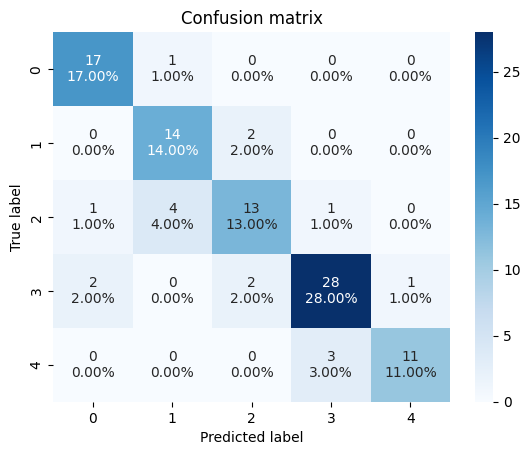

pred succeed


energy-kcal_100g  fat_100g  carbohydrates_100g  fiber_100g  \
25845         -1.518899 -0.747548           -1.119842   -0.699649   
8345           0.063486 -0.312256            0.402423   -0.158360   
3601           0.205147 -0.498909           -0.125760    0.859262   
9276           1.905081  1.699833            0.855101   -0.699649   
16557          0.633145  0.993617           -1.119842   -0.699649   

       proteins_100g  salt_100g True_value Prediction  
25845      -0.881508   1.864274          c          c  
8345        0.218137  -0.155105          c          b  
3601        3.606301   0.799560          d          d  
9276       -0.542189  -0.172453          e          e  
16557       1.811680   0.489470          e          e

In [9]:
pred = SUPMLENGINE.make_prediction(X=data_test_sample[list_ind],
                            col_name=list_ind,
                            Y=data_test_sample["nutrition-score"],
                            estimator=ls_model[1],
                            supervised_type= "cla")

pred.head()